# XGBoost model to predict molecule Solubility from SMILES

ESOL (delaney) is a standard regression dataset containing structures and water solubility data for 1128 compounds. The dataset is a good standard for for estimating solubility directly from molecular structures (as encoded in SMILES strings) using Machine Learning.

*Reference:*

*Delaney, John S. "ESOL: estimating aqueous solubility directly from molecular structure." Journal of chemical information and computer sciences 44.3 (2004): 1000-1005.*

### Installs

Install relevant packages. Google colab has a lot of packages already preinstalled. 

In [1]:
!pip install gsutil

!pip install sklearn
!pip install xgboost

!pip install rdkit-pypi

!pip install alibi==0.6.4
!pip install seldon_deploy_sdk

/home/seldon/anaconda3/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/home/seldon/anaconda3/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/home/seldon/anaconda3/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/home/seldon/anaconda3/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes


/home/seldon/anaconda3/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/home/seldon/anaconda3/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/home/seldon/anaconda3/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/home/seldon/anaconda3/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/home/seldon/anaconda3/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is depre

^C
ERROR: Operation cancelled by user


### Imports

Import the libraries required for data prcoessing, normalising smile strings, data visualisation, modelling, and monitoring (alibi detect and alibi explain); as well as the Seldon Deploy Python SDK.

In [1]:
# Data processing
import json
import pandas as pd
import numpy as np
import itertools

from rdkit import Chem
from rdkit.Chem import Draw, PandasTools

# Data visualisation
import seaborn as sns

# Modelling
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, accuracy_score, r2_score
from xgboost import XGBRegressor


from alibi.explainers import AnchorTabular

# Seldon Deploy Python sdk 
from seldon_deploy_sdk import Configuration, SeldonDeploymentsApi, ApiClient
from seldon_deploy_sdk.auth import OIDCAuthenticator

### Get Data

Visualise original ESOL Delaney dataset

In [2]:
!gsutil cp gs://kelly-seldon/molecule-solubility-smile/ESOL_delaney-processed.csv ESOL_delaney-processed.csv

Copying gs://kelly-seldon/molecule-solubility-smile/ESOL_delaney-processed.csv...
/ [1 files][ 94.4 KiB/ 94.4 KiB]                                                
Operation completed over 1 objects/94.4 KiB.                                     


In [56]:
df_exp = pd.read_csv('ESOL_delaney-processed.csv')
df_exp.head()

,Compound ID,ESOL predicted log solubility in mols per litre,Minimum Degree,Molecular Weight,Number of H-Bond Donors,Number of Rings,Number of Rotatable Bonds,Polar Surface Area,measured log solubility in mols per litre,smiles
0,Amigdalin,-0.974,1,457.432,7,3,7,202.32,-0.77,OCC3OC(OCC2OC(OC(C#N)c1ccccc1)C(O)C(O)C2O)C(O)C(O)C3O
1,Fenfuram,-2.885,1,201.225,1,2,2,42.24,-3.30,Cc1occc1C(=O)Nc2ccccc2
2,citral,-2.579,1,152.237,0,0,4,17.07,-2.06,CC(C)=CCCC(C)=CC(=O)
3,Picene,-6.618,2,278.354,0,5,0,0.00,-7.87,c1ccc2c(c1)ccc3c2ccc4c5ccccc5ccc43
4,Thiophene,-2.232,2,84.143,0,1,0,0.00,-1.33,c1ccsc1


Visualise dataset we will be working with today with just the smile strings and measured log(s) remaining

The original dataset contains the following columns:

* Compound ID
* ESOL predicted log solubility in mols per litre
* Minimum Degree
* Molecular Weight
* Number of H-Bond Donors
* Number of Rings
* Number of Rotatable Bonds
* Polar Surface Area
* measured log solubility in mols per litre
* smiles

Whilst using some of the molecule characteristics, such of 'Number of Rings' or 'Molecular Weight' would probably improve the performance of an ML model to predict solubility, for the sake of this workshop, we are just going to take our SMILES, one hot encode them in terms of atom/bond type and atom/bond position in the smile string and then use the resultant vectors to train an XGBoost Regression model. This will decrease model performance as some of the structural properties that are key to solubility will be lost and if we were doing this in a more real world setting, computational analysis of each molecule we were working with would be carried out and the added information would be included in the vectors of our SMILES.

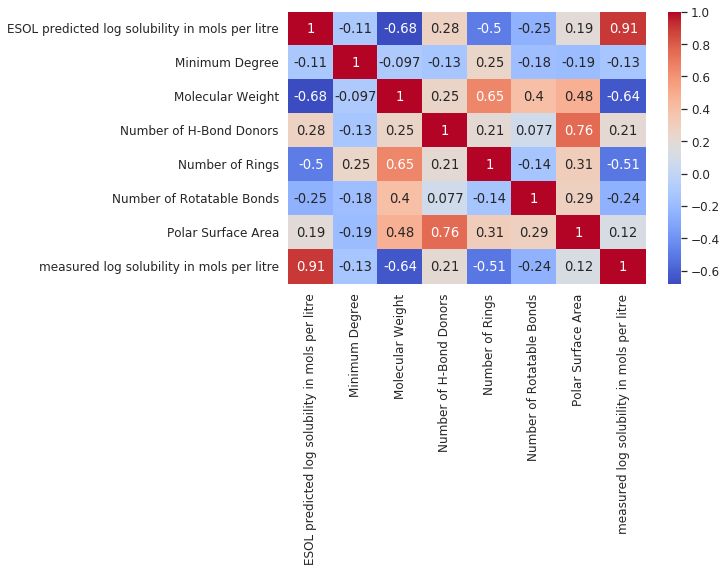

In [58]:
sns.heatmap(df_exp.corr(), annot = True, fmt='.2g',cmap= 'coolwarm')

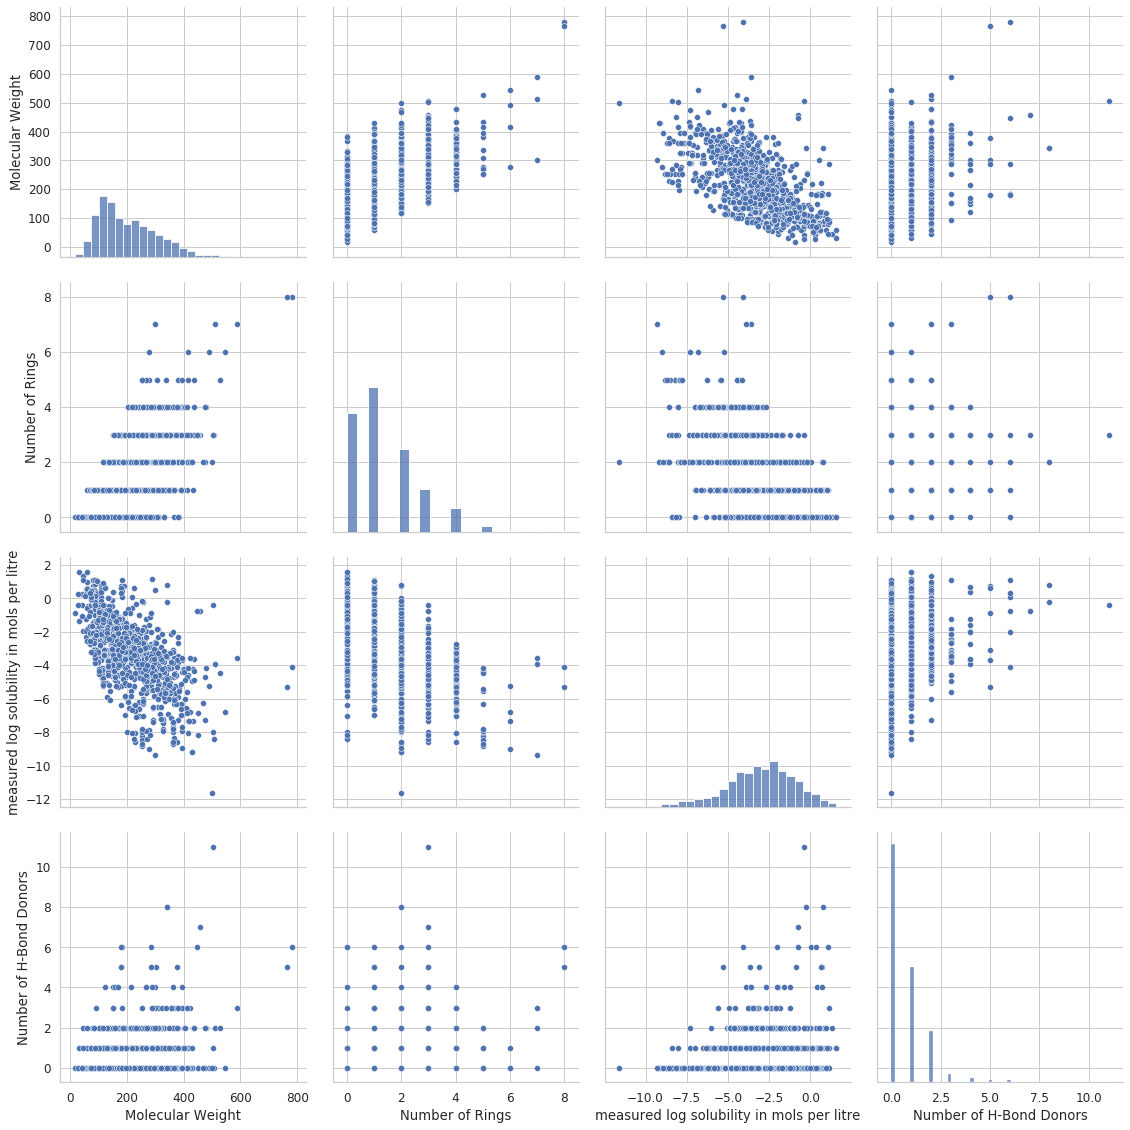

In [73]:
sns.pairplot(
    df_exp[['Molecular Weight', 'Number of Rings', 'measured log solubility in mols per litre', 'Number of H-Bond Donors']], 
    height=4
)

In [4]:
!gsutil cp gs://kelly-seldon/molecule-solubility-smile/esol_smiles.csv esol_smiles.csv

Copying gs://kelly-seldon/molecule-solubility-smile/esol_smiles.csv...
/ [1 files][ 49.4 KiB/ 49.4 KiB]                                                
Operation completed over 1 objects/49.4 KiB.                                     


In [57]:
df = pd.read_csv('esol_smiles.csv')
df.head()

,compound_id,smiles,measured_log_solubility
0,Amigdalin,OCC3OC(OCC2OC(OC(C#N)c1ccccc1)C(O)C(O)C2O)C(O)C(O)C3O,-0.77
1,citral,CC(C)=CCCC(C)=CC(=O),-2.06
2,Picene,c1ccc2c(c1)ccc3c2ccc4c5ccccc5ccc43,-7.87
3,Thiophene,c1ccsc1,-1.33
4,benzothiazole,c2ccc1scnc1c2,-1.50


Get batch sample to run batch predict and feedback jobs later on

### Visualise target variable

[Text(0, 0.5, 'Count'), Text(0.5, 0, 'Log s (solubility)')]

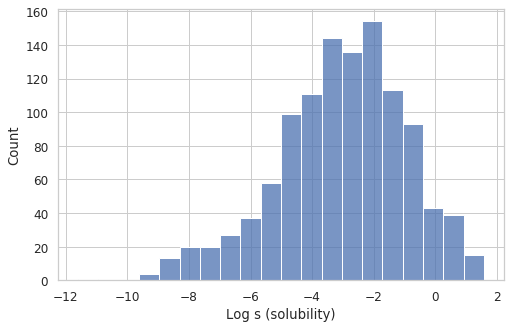

In [6]:
sns.set(style='whitegrid', palette="deep", font_scale=1.1, rc={"figure.figsize": [8, 5]})
sns.histplot(df['measured_log_solubility'], kde=False, bins=20).set(xlabel='Log s (solubility)', ylabel='Count')

### Normalise smiles strings

In [7]:
# Get uniform smiles
df["uniform_smiles"] = [Chem.MolToSmiles(Chem.MolFromSmiles(smi), kekuleSmiles=True,isomericSmiles=True) 
                              for smi in df["smiles"]]

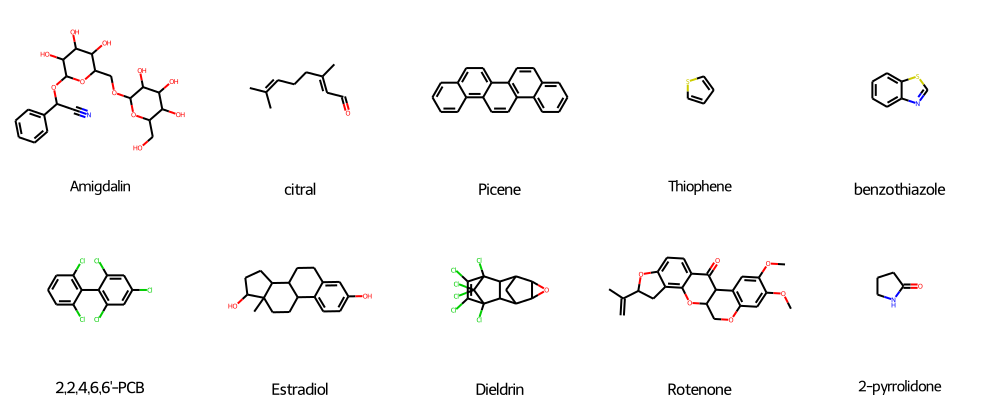

In [8]:
# Using PandasTools and the respective Draw method
PandasTools.AddMoleculeColumnToFrame(df, smilesCol="uniform_smiles", molCol="Mol2D")
Draw.MolsToGridImage(list(df.Mol2D[0:10]), legends=list(df.compound_id[0:20]), molsPerRow=5)

### Get 2 letter elements for replacement

In [9]:
# Get unique characters across all SMILE strings
unique_chars = set(df.uniform_smiles.apply(list).sum())

In [10]:
# List of all possible periodic elements
periodic_elements = [
    "Ac",
    "Al",
    "Am",
    "Sb",
    "Ar",
    "As",
    "At",
    "Ba",
    "Bk",
    "Be",
    "Bi",
    "Bh",
    "B",
    "Br",
    "Cd",
    "Ca",
    "Cf",
    "C",
    "Ce",
    "Cs",
    "Cl",
    "Cr",
    "Co",
    "Cn",
    "Cu",
    "Cm",
    "Ds",
    "Db",
    "Dy",
    "Es",
    "Er",
    "Eu",
    "Fm",
    "Fl",
    "F",
    "Fr",
    "Gd",
    "Ga",
    "Ge",
    "Au",
    "Hf",
    "Hs",
    "He",
    "Ho",
    "H",
    "In",
    "I",
    "Ir",
    "Fe",
    "Kr",
    "La",
    "Lr",
    "Pb",
    "Li",
    "Lv",
    "Lu",
    "Mg",
    "Mn",
    "Mt",
    "Md",
    "Hg",
    "Mo",
    "Mc",
    "Nd",
    "Ne",
    "Np",
    "Ni",
    "Nh",
    "Nb",
    "N",
    "No",
    "Og",
    "Os",
    "O",
    "Pd",
    "P",
    "Pt",
    "Pu",
    "Po",
    "K",
    "Pr",
    "Pm",
    "Pa",
    "Ra",
    "Rn",
    "Re",
    "Rh",
    "Rg",
    "Rb",
    "Ru",
    "Rf",
    "Sm",
    "Sc",
    "Sg",
    "Se",
    "Si",
    "Ag",
    "Na",
    "Sr",
    "S",
    "Ta",
    "Tc",
    "Te",
    "Ts",
    "Tb",
    "Tl",
    "Th",
    "Tm",
    "Sn",
    "Ti",
    "W",
    "U",
    "V",
    "Xe",
    "Yb",
    "Y",
    "Zn",
    "Zr",
]

In [11]:
upper_case = []
lower_case = []

for char in unique_chars:
    if char.isupper():
        upper_case.append(char)
    elif char.islower():
        lower_case.append(char)

two_char_elements = []
for char_u in upper_case:
    for char_l in lower_case:
        comb = char_u + char_l
        if comb in periodic_elements:
            two_char_elements.append(comb)        
            
two_char_elements_conf = []
for two_char_element in two_char_elements:
    if df.uniform_smiles.str.contains(two_char_element).any():
        two_char_elements_conf.append(two_char_element)

In [12]:
# If we had isomers, would also have @@ to replace here, but we don't 
two_char_replace = {"Cl": "L", "Br": "R"}

Note - in a more real world scenario, we would ensure that our training set contains instances of all elements that may appear in unseen molecules

In [13]:
df.drop(columns="Mol2D", axis=1, inplace=True)

### Get data for running batch jobs

In [14]:
df_batch = df.sample(n=100)
batch_nums = df_batch.index.to_list()
df.drop(batch_nums, axis=0, inplace=True)
df_batch.reset_index(inplace=True, drop=True)
df.reset_index(inplace=True, drop=True)

In [15]:
df.shape

(1027, 4)

### Split into training and testing data

In [16]:
Y = df['measured_log_solubility']
X = df['uniform_smiles']

In [17]:
longest_smile = max(X, key=len)

In [18]:
trainX, testX, trainY, testY = train_test_split(X, Y, test_size = 0.15, random_state = 42)

In [19]:
df = pd.DataFrame(trainX)

unique_chars = [
        'S',
        '/',
        '1',
        'F',
        'I',
        'C',
        '+',
        '[',
        'L',
        '\\',
        'O',
        '-',
        'N',
        '(',
        '5',
        '4',
        'P',
        'R',
        '#',
        '7',
        ']',
        '2',
        '=',
        ')',
        '6',
        '3'
    ]

def one_hot_encode_smiles(df, unique_chars, longest_smile):

    df["single_char_smiles"] = df["uniform_smiles"].copy()

    # Swap 2-character elements for single character elements
    for k, v in two_char_replace.items():
        df["single_char_smiles"] = df["single_char_smiles"].str.replace(k, v)
        
    smi_to_ind = dict((c, i) for i, c in enumerate(unique_chars))
    ind_to_smi = dict((i, c) for i, c in enumerate(unique_chars))

    # One hot encoding of smile strings with padding set to length of longest smile string in the dataset
    # Ensure all model input vectors are the same size

    def smiles_encoder(smiles, max_len_smile, unique_char):
        X = np.zeros((max_len_smile, len(unique_char)))
        for i, c in enumerate(smiles):
            X[i, smi_to_ind[c]] = 1
        return X

    df["unique_char_ohe_matrix"] = df["single_char_smiles"].apply(
        smiles_encoder, max_len_smile=len(longest_smile), unique_char=unique_chars
    )
    
    return df

In [20]:
trainX = one_hot_encode_smiles(df, unique_chars, longest_smile)
X_ohe = trainX['unique_char_ohe_matrix']

In [21]:
def replace_square_brackets(unique_chars):
    # Find the index of open and closed square brackets
    for bracket in ['[', ']']:
        if bracket == '[':
            to_rpl = 'openbracket'
        else:
            to_rpl = 'closedbracket'
        i = unique_chars.index(bracket)
        unique_chars = unique_chars[:i]+[to_rpl]+unique_chars[i+1:]
    
    return unique_chars

In [22]:
rpl_unique_chars = replace_square_brackets(unique_chars)

In [23]:
def get_new_features(rpl_unique_chars):
    
    num_rng_str = []
    
    for i in range(1,98):
        num_rng_str.append(str(i))

    c = list(itertools.product(num_rng_str, rpl_unique_chars))

    # Function that converts tuple to string
    def join_tuple_string(c):
        return '_'.join(c)
    # Joining all the tuples

    result = map(join_tuple_string, c)
    cols = list(result)

    # Create new df with (97*26) columns
    df_ohe = pd.DataFrame(columns=cols, dtype='object')
        
    return df_ohe

In [24]:
trainX_df_ohe = get_new_features(rpl_unique_chars)

In [25]:
def add_smile_vectors(df_new, df_ohe):

    result = [x.flatten() for x in df_ohe]

    j = 0

    for arr in result:
        df_new.loc[j] = arr
        j += 1
    
    return df_new
    

In [26]:
trainX_df_ohe = add_smile_vectors(trainX_df_ohe, X_ohe)

In [27]:
trainY.reset_index(drop=True, inplace=True)

In [28]:
model = XGBRegressor(n_estimators=1000, max_depth=3, eta=0.12, subsample=1.0, colsample_bytree=1.0)
model.fit(trainX_df_ohe, trainY)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1.0,
             early_stopping_rounds=None, enable_categorical=False, eta=0.12,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.119999997, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=3, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=1000,
             n_jobs=0, num_parallel_tree=1, objective='reg:squarederror',
             predictor='auto', random_state=0, ...)

In [29]:
model.save_model('model.bst')

### Deploy model 

In [36]:
YOUR_NAME = 'kelly-spry'

!gsutil cp model.bst gs://kelly-seldon/molecule-solubility-smile/models/{YOUR_NAME}/model.bst

Copying file://model.bst [Content-Type=application/octet-stream]...
- [1 files][562.5 KiB/562.5 KiB]                                                
Operation completed over 1 objects/562.5 KiB.                                    


In [37]:
SD_IP = "34.90.37.115"

config = Configuration()
config.host = f"http://{SD_IP}/seldon-deploy/api/v1alpha1"
config.oidc_client_id = "sd-api"
config.oidc_server = f"http://{SD_IP}/auth/realms/deploy-realm"
config.oidc_client_secret = "sd-api-secret"
config.auth_method = "client_credentials"

def auth():
    auth = OIDCAuthenticator(config)
    config.id_token = auth.authenticate()
    api_client = ApiClient(configuration=config, authenticator=auth)
    return api_client

In [61]:
DEPLOYMENT_NAME = "kelly-smiles-test"
NAMESPACE = "seldon-gitops"
MODEL_LOCATION = f"gs://kelly-seldon/molecule-solubility-smile/models/{YOUR_NAME}/model.bst"

PREPACKAGED_SERVER = "XGBOOST_SERVER"

CPU_REQUESTS = "0.1"
MEMORY_REQUESTS = "1Gi"

CPU_LIMITS = "0.1"
MEMORY_LIMITS = "1Gi"

mldeployment = {
    "kind": "SeldonDeployment",
    "metadata": {
        "name": DEPLOYMENT_NAME,
        "namespace": NAMESPACE,
        "labels": {
            "fluentd": "true"
        }
    },
    "apiVersion": "machinelearning.seldon.io/v1alpha2",
    "spec": {
        "name": DEPLOYMENT_NAME,
        "annotations": {
            "seldon.io/engine-seldon-log-messages-externally": "true"
        },
        "protocol": "seldon",
        "transport": "rest",
        "predictors": [
            {
                "componentSpecs": [
                    {
                        "spec": {
                            "containers": [
                                {
                                    "name": f"{DEPLOYMENT_NAME}-container",
                                    "resources": {
                                        "requests": {
                                            "cpu": CPU_REQUESTS,
                                            "memory": MEMORY_REQUESTS
                                        },
                                        "limits": {
                                            "cpu": CPU_LIMITS,
                                            "memory": MEMORY_LIMITS
                                        }
                                    }
                                }
                            ]
                        }
                    }
                ],
                "name": "default",
                "replicas": 1,
                "traffic": 100,
                "graph": {
                    "implementation": PREPACKAGED_SERVER,
                    "modelUri": MODEL_LOCATION,
                    "name": f"{DEPLOYMENT_NAME}-container",
                    "endpoint": {
                        "type": "REST"
                    },
                    "parameters": [],
                    "children": [],
                    "logger": {
                        "mode": "all"
                    }
                }
            }
        ]
    },
    "status": {}
}

In [62]:
deployment_api = SeldonDeploymentsApi(auth())
deployment_api.create_seldon_deployment(namespace=NAMESPACE, mldeployment=mldeployment)

{'api_version': 'machinelearning.seldon.io/v1alpha2',
 'kind': 'SeldonDeployment',
 'metadata': {'annotations': None,
              'cluster_name': None,
              'creation_timestamp': None,
              'deletion_grace_period_seconds': None,
              'deletion_timestamp': None,
              'finalizers': None,
              'generate_name': None,
              'generation': None,
              'labels': {'fluentd': 'true'},
              'managed_fields': None,
              'name': 'kelly-smiles-test',
              'namespace': 'seldon-gitops',
              'owner_references': None,
              'resource_version': None,
              'self_link': None,
              'uid': None},
 'spec': {'annotations': {'seldon.io/engine-seldon-log-messages-externally': 'true'},
          'name': 'kelly-smiles-test',
          'oauth_key': None,
          'oauth_secret': None,
          'predictors': [{'annotations': None,
                          'component_specs': [{'hpa_spec': N

### Send request to model

**Can copy request json example below:**

```
{
	"data": {
		"ndarray": [
			[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
		]
	}
}
```

**or download request json file and upload it on Seldon Deploy UI:**

In [239]:
!gsutil cp gs://kelly-seldon/molecule-solubility-smile/test_request.json test_request.json
with open("test_request.json") as json_file:
    json_data = json.load(json_file)

with open('test_request.json', 'w') as f:
    json.dump(json_data, f)    

from IPython.display import FileLink, FileLinks
FileLink('test_request.json')

Copying gs://kelly-seldon/molecule-solubility-smile/test_request.json...
/ [1 files][ 12.4 KiB/ 12.4 KiB]                                                
Operation completed over 1 objects/12.4 KiB.                                     


/home/seldon/PycharmProjects/deploy-workshops/molecule-solubility-smiles/test_request.json

### Test model 

In [30]:
df = pd.DataFrame(testX)

longest_smile = max(X, key=len)
unique_chars = [
        'S',
        '/',
        '1',
        'F',
        'I',
        'C',
        '+',
        '[',
        'L',
        '\\',
        'O',
        '-',
        'N',
        '(',
        '5',
        '4',
        'P',
        'R',
        '#',
        '7',
        ']',
        '2',
        '=',
        ')',
        '6',
        '3'
    ]

testX = one_hot_encode_smiles(df, unique_chars, longest_smile)
X_ohe = testX['unique_char_ohe_matrix']
rpl_unique_chars = replace_square_brackets(unique_chars)
testX_df_ohe = get_new_features(rpl_unique_chars)
testX_df_ohe = add_smile_vectors(testX_df_ohe, X_ohe)

In [31]:
preds = model.predict(testX_df_ohe)

In [32]:
rmse = np.sqrt(mean_squared_error(testY, preds))
print("RMSE: %f" % (rmse))

RMSE: 1.083711


In [33]:
actuals = testY.reset_index(drop=True)

In [34]:
df_eval = pd.DataFrame(columns=['preds', 'actuals'], dtype='object')

In [35]:
df_eval['preds'] = preds
df_eval['actuals'] = actuals
df_eval['diff'] = df_eval['preds'] - df_eval['actuals']

In [36]:
pd.set_option('display.max_columns', None)  # or 1000
pd.set_option('display.max_rows', None)  # or 1000
pd.set_option('display.max_colwidth', None)  # or 199

In [37]:
df_eval

,preds,actuals,diff
0,-3.446015,-4.150,0.703985
1,-5.591269,-7.110,1.518731
2,-4.994153,-3.810,-1.184153
3,-4.179421,-4.700,0.520579
4,-8.185257,-8.017,-0.168257
5,-3.653694,-4.740,1.086306
6,-3.586486,-2.460,-1.126486
7,-0.195808,0.620,-0.815808
8,-3.261294,-3.140,-0.121294
9,-1.882558,-2.700,0.817442


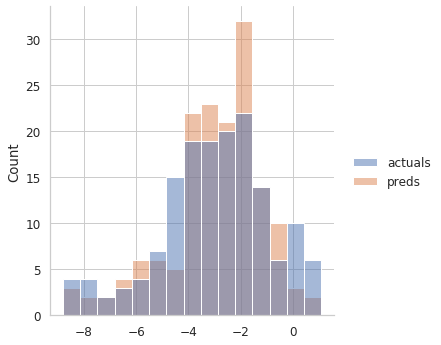

In [38]:
sns.displot(df_eval[['actuals', 'preds']])

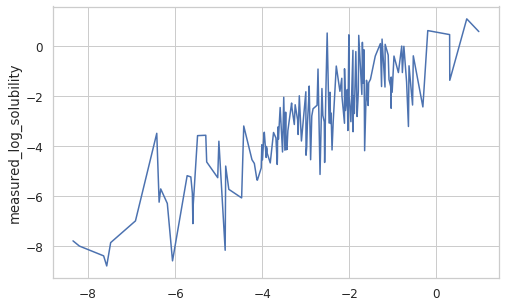

In [39]:
sns.lineplot(x=preds, y=actuals)

In [40]:
r2_score(actuals, preds)

0.7357934776770754

### Run batch prediction

In [42]:
df_batch.head()

,compound_id,smiles,measured_log_solubility,uniform_smiles
0,Prednisolone,CC12CC(O)C3C(CCC4=CC(=O)C=CC34C)C2CCC1(O)C(=O)CO,-3.180,CC12C=CC(=O)C=C1CCC1C2C(O)CC2(C)C1CCC2(O)C(=O)CO
1,"5,5-Diisopropylbarbital",O=C1NC(=O)NC(=O)C1(C(C)C)C(C)C,-2.766,CC(C)C1(C(C)C)C(=O)NC(=O)NC1=O
2,4-Methyl-2-pentanol,CC(C)CC(C)O,-0.800,CC(C)CC(C)O
3,"2,2',3,3',4,4',5,5'-PCB",Clc1cc(c(Cl)c(Cl)c1Cl)c2cc(Cl)c(Cl)c(Cl)c2Cl,-9.160,ClC1=CC(C2=CC(Cl)=C(Cl)C(Cl)=C2Cl)=C(Cl)C(Cl)=C1Cl
4,mercaptobenzothiazole,Sc2nc1ccccc1s2,-3.180,SC1=NC2=CC=CC=C2S1


In [43]:
batchX = df_batch['uniform_smiles']

In [44]:
df = pd.DataFrame(batchX)

longest_smile = max(X, key=len)
unique_chars = [
        'S',
        '/',
        '1',
        'F',
        'I',
        'C',
        '+',
        '[',
        'L',
        '\\',
        'O',
        '-',
        'N',
        '(',
        '5',
        '4',
        'P',
        'R',
        '#',
        '7',
        ']',
        '2',
        '=',
        ')',
        '6',
        '3'
    ]

batchX = one_hot_encode_smiles(df, unique_chars, longest_smile)
batchX_ohe = batchX['unique_char_ohe_matrix']
rpl_unique_chars = replace_square_brackets(unique_chars)
batchX_df_ohe = get_new_features(rpl_unique_chars)
batchX_df_ohe = add_smile_vectors(batchX_df_ohe, batchX_ohe)

In [45]:
batchX_df_ohe.head()

1_S  1_/  1_1  1_F  1_I  1_C  1_+  1_openbracket  1_L  1_\  1_O  1_-  1_N  \
0  0.0  0.0  0.0  0.0  0.0  1.0  0.0            0.0  0.0  0.0  0.0  0.0  0.0   
1  0.0  0.0  0.0  0.0  0.0  1.0  0.0            0.0  0.0  0.0  0.0  0.0  0.0   
2  0.0  0.0  0.0  0.0  0.0  1.0  0.0            0.0  0.0  0.0  0.0  0.0  0.0   
3  0.0  0.0  0.0  0.0  0.0  0.0  0.0            0.0  1.0  0.0  0.0  0.0  0.0   
4  1.0  0.0  0.0  0.0  0.0  0.0  0.0            0.0  0.0  0.0  0.0  0.0  0.0   

   1_(  1_5  1_4  1_P  1_R  1_#  1_7  1_closedbracket  1_2  1_=  1_)  1_6  \
0  0.0  0.0  0.0  0.0  0.0  0.0  0.0              0.0  0.0  0.0  0.0  0.0   
1  0.0  0.0  0.0  0.0  0.0  0.0  0.0              0.0  0.0  0.0  0.0  0.0   
2  0.0  0.0  0.0  0.0  0.0  0.0  0.0              0.0  0.0  0.0  0.0  0.0   
3  0.0  0.0  0.0  0.0  0.0  0.0  0.0              0.0  0.0  0.0  0.0  0.0   
4  0.0  0.0  0.0  0.0  0.0  0.0  0.0              0.0  0.0  0.0  0.0  0.0   

   1_3  2_S  2_/  2_1  2_F  2_I  2_C  2_+  2_openbracket  2_L  2_\  2_O  2_-  \
0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0            0.0  0.0  0.0  0.0  0.0   
1  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0            0.0  0.0  0.0  0.0  0.0   
2  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0            0.0  0.0  0.0  0.0  0.0   
3  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0            0.0  0.0  0.0  0.0  0.0   
4  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0            0.0  0.0  0.0  0.0  0.0   

   2_N  2_(  2_5  2_4  2_P  2_R  2_#  2_7  2_closedbracket  2_2  2_=  2_)  \
0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0              0.0  0.0  0.0  0.0   
1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0              0.0  0.0  0.0  0.0   
2  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0              0.0  0.0  0.0  0.0   
3  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0              0.0  0.0  0.0  0.0   
4  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0              0.0  0.0  0.0  0.0   

   2_6  2_3  3_S  3_/  3_1  3_F  3_I  3_C  3_+  3_openbracket  3_L  3_\  3_O  \
0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0            0.0  0.0  0.0  0.0   
1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0            0.0  0.0  0.0  0.0   
2  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0            0.0  0.0  0.0  0.0   
3  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0            0.0  0.0  0.0  0.0   
4  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0            0.0  0.0  0.0  0.0   

   3_-  3_N  3_(  3_5  3_4  3_P  3_R  3_#  3_7  3_closedbracket  3_2  3_=  \
0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0              0.0  0.0  0.0   
1  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0              0.0  0.0  0.0   
2  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0              0.0  0.0  0.0   
3  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0              0.0  0.0  0.0   
4  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0              0.0  0.0  0.0   

   3_)  3_6  3_3  4_S  4_/  4_1  4_F  4_I  4_C  4_+  4_openbracket  4_L  4_\  \
0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0            0.0  0.0  0.0   
1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0            0.0  0.0  0.0   
2  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0            0.0  0.0  0.0   
3  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0            0.0  0.0  0.0   
4  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0            0.0  0.0  0.0   

   4_O  4_-  4_N  4_(  4_5  4_4  4_P  4_R  4_#  4_7  4_closedbracket  4_2  \
0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0              0.0  1.0   
1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0              0.0  0.0   
2  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0              0.0  0.0   
3  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0              0.0  0.0   
4  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0              0.0  0.0   

   4_=  4_)  4_6  4_3  5_S  5_/  5_1  5_F  5_I  5_C  5_+  5_openbracket  5_L  \
0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0            0.0  0.0   
1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0           

In [46]:
arr = pd.DataFrame(batchX_df_ohe).to_numpy()

In [54]:
a_file = open("test.txt", "w")
for row in arr:
    row_arr = np.asarray(row)
    np.savetxt(a_file, row_arr)

a_file.close()

In [49]:
rec_arr = batchX_df_ohe.to_records(index=False)

### Add an Explainer

In [51]:
trainX_df_ohe.shape

(924, 2522)

In [52]:
def predict_fn(x):
    return model.predict(x)

columns = list(trainX_df_ohe.columns)
explainer = AnchorTabular(predict_fn, columns)

In [53]:
trainX_arr = trainX_df_ohe.to_numpy()

In [54]:
explainer.fit(trainX_arr, disc_perc=(25, 50, 75)) 

AnchorTabular(meta={
  'name': 'AnchorTabular',
  'type': ['blackbox'],
  'explanations': ['local'],
  'params': {'disc_perc': (25, 50, 75), 'seed': None},
  'version': '0.6.4'}
)

In [55]:
explainer.save('smiles-explainer')

In [57]:
!gsutil cp -r smiles-explainer gs://kelly-seldon/molecule-solubility-smile/models/{YOUR_NAME}/smiles-explainer

Copying file://smiles-explainer/explainer.dill [Content-Type=application/octet-stream]...
Copying file://smiles-explainer/meta.dill [Content-Type=application/octet-stream]...
| [2 files][ 55.4 MiB/ 55.4 MiB]    1.6 MiB/s                                   
Operation completed over 2 objects/55.4 MiB.                                     


### Deploy Explainer

In [63]:
EXPLAINER_TYPE = "AnchorTabular"
EXPLAINER_URI = f"gs://kelly-seldon/molecule-solubility-smile/models/{YOUR_NAME}/smiles-explainer"

explainer_spec = {
                    "type": EXPLAINER_TYPE,
                    "modelUri": EXPLAINER_URI,
                    "containerSpec": {
                        "name": "",
                        "resources": {}
                    }
                }

In [64]:
mldeployment['spec']['predictors'][0]['explainer'] = explainer_spec
mldeployment

{'kind': 'SeldonDeployment',
 'metadata': {'name': 'kelly-smiles-test',
  'namespace': 'seldon-gitops',
  'labels': {'fluentd': 'true'}},
 'apiVersion': 'machinelearning.seldon.io/v1alpha2',
 'spec': {'name': 'kelly-smiles-test',
  'annotations': {'seldon.io/engine-seldon-log-messages-externally': 'true'},
  'protocol': 'seldon',
  'transport': 'rest',
  'predictors': [{'componentSpecs': [{'spec': {'containers': [{'name': 'kelly-smiles-test-container',
         'resources': {'requests': {'cpu': '0.1', 'memory': '1Gi'},
          'limits': {'cpu': '0.1', 'memory': '1Gi'}}}]}}],
    'name': 'default',
    'replicas': 1,
    'traffic': 100,
    'graph': {'implementation': 'XGBOOST_SERVER',
     'modelUri': 'gs://kelly-seldon/molecule-solubility-smile/models/kelly-spry/model.bst',
     'name': 'kelly-smiles-test-container',
     'endpoint': {'type': 'REST'},
     'parameters': [],
     'children': [],
     'logger': {'mode': 'all'}},
    'explainer': {'type': 'AnchorTabular',
     'modelUr

In [65]:
deployment_api = SeldonDeploymentsApi(auth())
deployment_api.create_seldon_deployment(namespace=NAMESPACE, mldeployment=mldeployment)

{'api_version': 'machinelearning.seldon.io/v1alpha2',
 'kind': 'SeldonDeployment',
 'metadata': {'annotations': None,
              'cluster_name': None,
              'creation_timestamp': None,
              'deletion_grace_period_seconds': None,
              'deletion_timestamp': None,
              'finalizers': None,
              'generate_name': None,
              'generation': None,
              'labels': {'fluentd': 'true'},
              'managed_fields': None,
              'name': 'kelly-smiles-test',
              'namespace': 'seldon-gitops',
              'owner_references': None,
              'resource_version': None,
              'self_link': None,
              'uid': None},
 'spec': {'annotations': {'seldon.io/engine-seldon-log-messages-externally': 'true'},
          'name': 'kelly-smiles-test',
          'oauth_key': None,
          'oauth_secret': None,
          'predictors': [{'annotations': None,
                          'component_specs': [{'hpa_spec': N